In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import os

import time
from datetime import timedelta

#### Batch size
If memory error, reduce the batch_size.

In [2]:
batch_size = 32
num_workers = 4

#### [ImageFolder](https://github.com/pytorch/vision/blob/master/torchvision/datasets/folder.py)
A generic data loader where the samples are arranged in this way:
```
    root/dog/xxx.png
    root/dog/xxy.png
    root/dog/xxz.png
    root/cat/123.png
    root/cat/nsdf3.png
    root/cat/asd932_.png
    
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
```

In [31]:
# Data loading code
datasetsdir = '../DataSet/breed'
traindir = os.path.join(datasetsdir)
#valdir = os.path.join(datasetsdir, 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(traindir, transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-30, 30)),
        transforms.ToTensor(),
        normalize,
    ])), 
    batch_size=batch_size, shuffle=True,
    num_workers=num_workers)

# val_loader = torch.utils.data.DataLoader(
#     datasets.ImageFolder(valdir, transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         normalize,
#     ])),
#     batch_size=batch_size, shuffle=False,
#     num_workers=num_workers)

classes = [d for d in os.listdir(traindir) if os.path.isdir(os.path.join(traindir, d))]
classes.sort()
print(len(classes))
print(classes)

120
['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', '

Train + Validation

In [44]:
from tqdm import tqdm

def train(model, loader, loss_fn, optimizer, num_epochs,device,save_path):
    start_time = time.time()
    best =0
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        batch_start = time.time()
        for t, (x, y) in enumerate(tqdm(loader, desc=f"Epoch {epoch + 1}/{num_epochs}", ncols=100)):
            x_var = x.to(device)
            y_var = y.to(device)
            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % 100 == 0:
                #print('t = %d, loss = %.4f, duration = %s' % (t + 1, loss.item(), timedelta(seconds=time.time() - batch_start)))
                batch_start = time.time()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        best =check_accuracy(model,loader,save_path,device,best)
    print('Duration = %s' % timedelta(seconds=time.time() - start_time))

def check_accuracy(model, loader,save_path,device,best):
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    start_time = time.time()
    print('Checking accuracy on validation set')
    for x, y in loader:
        with torch.no_grad():
            x_var = x.to(device)

            scores = model(x_var)
            _, preds = scores.data.cpu().max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    print('Duration = %s' % timedelta(seconds=time.time() - start_time))
    if save_path and num_correct>best:
        best = num_correct
        print(f'Saving model to {save_path}')
        torch.save(model.state_dict(), save_path)
        print('Model saved.')
    return best

#### [Pre-trained models](https://pytorch.org/docs/master/torchvision/models.html)

- [VGG16](https://arxiv.org/abs/1409.1556)
- [ResNet](https://arxiv.org/abs/1512.03385)

As always, add one more FC layer or replace the last FC layer with the number of output classes.

In [47]:
def vgg16(pretrained=False, device="cuda:0",weights_path='../regression/weights/vgg16/vgg16-397923af.pth'):
    model = models.vgg16(pretrained=pretrained)
    def set_untrainable(layer):
        for p in layer.parameters():
            p.requires_grad = False

    # Freeze layers
    # for layer in model.children():
    #     layer.apply(set_untrainable)
    if weights_path:
        print(f"Loading weights from {weights_path}")
        model.load_state_dict(torch.load(weights_path,weights_only=True))
    # Modify the classifier
    model.classifier = nn.Sequential(*(list(model.classifier.children()) + [nn.ReLU(inplace=True), nn.Linear(1000, 120)]))
    
    # Load the pre-trained weights if provided
    
    
    model.to(device)
    return model
    
def resnet34(pretrained=True):
    model = models.resnet34(pretrained=pretrained)
    def set_untrainable(layer):
        for p in layer.parameters():
            p.requires_grad = False

    for layer in model.children():
        layer.apply(set_untrainable)
    model.fc = nn.Linear(512, 120)
    model.cuda()
    return model

def resnet50(pretrained=True,device="cuda",weights='IMAGENET1K_V1',weights_path='../regression/results/vgg16/best_model.pth'):
    model = models.resnet50(weights=weights)  # 现在使用weights参数
    def set_untrainable(layer):
        for p in layer.parameters():
            p.requires_grad = False

    # for layer in model.children():
    #     layer.apply(set_untrainable)
    model.fc = nn.Sequential(model.fc, nn.Dropout(p=.5), nn.ReLU(inplace=True), nn.Linear(1000, 120))
    if weights_path:
        # Load custom weights if the path is provided
        print(f"Loading weights from {weights_path}")
        model.load_state_dict(torch.load(weights_path))
        print("Custom weights loaded.")
    model.to(device)
    return model

#### ResNet50

In [48]:
dev =torch.device("cuda:6")
model = resnet50(device=dev)

loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-3)


save_path ="../regression/results/vgg16/dbest_model.pth"
train(model, train_loader, loss_fn, optimizer, num_epochs=100,save_path=save_path,device=dev)

/tmp/ipykernel_2768710/673343955.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path))


Loading weights from ../regression/results/vgg16/best_model.pth
Custom weights loaded.
Starting epoch 1 / 100


Epoch 1/100: 100%|████████████████████████████████████████████████| 320/320 [00:13<00:00, 23.81it/s]

Checking accuracy on validation set


Got 5351 / 10222 correct (52.35)
Duration = 0:00:12.092857
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 2 / 100


Epoch 2/100: 100%|████████████████████████████████████████████████| 320/320 [00:17<00:00, 18.61it/s]

Checking accuracy on validation set


Got 5683 / 10222 correct (55.60)
Duration = 0:00:14.113344
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 3 / 100


Epoch 3/100: 100%|████████████████████████████████████████████████| 320/320 [00:14<00:00, 21.82it/s]

Checking accuracy on validation set


Got 5603 / 10222 correct (54.81)
Duration = 0:00:15.719581
Starting epoch 4 / 100


Epoch 4/100: 100%|████████████████████████████████████████████████| 320/320 [00:15<00:00, 21.25it/s]

Checking accuracy on validation set


Got 5818 / 10222 correct (56.92)
Duration = 0:00:12.396419
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 5 / 100


Epoch 5/100: 100%|████████████████████████████████████████████████| 320/320 [00:16<00:00, 19.41it/s]

Checking accuracy on validation set


Got 5945 / 10222 correct (58.16)
Duration = 0:00:15.468784
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 6 / 100


Epoch 6/100: 100%|████████████████████████████████████████████████| 320/320 [00:14<00:00, 21.98it/s]

Checking accuracy on validation set


Got 5872 / 10222 correct (57.44)
Duration = 0:00:12.289418
Starting epoch 7 / 100


Epoch 7/100: 100%|████████████████████████████████████████████████| 320/320 [00:14<00:00, 22.75it/s]


Checking accuracy on validation set
Got 5873 / 10222 correct (57.45)
Duration = 0:00:11.473998
Starting epoch 8 / 100


Epoch 8/100: 100%|████████████████████████████████████████████████| 320/320 [00:13<00:00, 24.16it/s]

Checking accuracy on validation set


Got 5832 / 10222 correct (57.05)
Duration = 0:00:12.021745
Starting epoch 9 / 100


Epoch 9/100: 100%|████████████████████████████████████████████████| 320/320 [00:13<00:00, 24.11it/s]

Checking accuracy on validation set


Got 5975 / 10222 correct (58.45)
Duration = 0:00:13.939703
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 10 / 100


Epoch 10/100: 100%|███████████████████████████████████████████████| 320/320 [00:17<00:00, 18.34it/s]

Checking accuracy on validation set


Got 5785 / 10222 correct (56.59)
Duration = 0:00:12.391822
Starting epoch 11 / 100


Epoch 11/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 23.36it/s]

Checking accuracy on validation set


Got 6049 / 10222 correct (59.18)
Duration = 0:00:12.112967
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 12 / 100


Epoch 12/100: 100%|███████████████████████████████████████████████| 320/320 [00:16<00:00, 19.54it/s]

Checking accuracy on validation set


Got 6199 / 10222 correct (60.64)
Duration = 0:00:12.840405
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 13 / 100


Epoch 13/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.21it/s]

Checking accuracy on validation set


Got 6146 / 10222 correct (60.13)
Duration = 0:00:11.788619
Starting epoch 14 / 100


Epoch 14/100: 100%|███████████████████████████████████████████████| 320/320 [00:17<00:00, 18.67it/s]

Checking accuracy on validation set


Got 6228 / 10222 correct (60.93)
Duration = 0:00:13.133753
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 15 / 100


Epoch 15/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.17it/s]

Checking accuracy on validation set


Got 5928 / 10222 correct (57.99)
Duration = 0:00:11.751819
Starting epoch 16 / 100


Epoch 16/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 22.00it/s]

Checking accuracy on validation set


Got 6335 / 10222 correct (61.97)
Duration = 0:00:12.911353
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 17 / 100


Epoch 17/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.10it/s]

Checking accuracy on validation set


Got 6185 / 10222 correct (60.51)
Duration = 0:00:11.827142
Starting epoch 18 / 100


Epoch 18/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 23.39it/s]

Checking accuracy on validation set


Got 5990 / 10222 correct (58.60)
Duration = 0:00:11.219866
Starting epoch 19 / 100


Epoch 19/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.06it/s]

Checking accuracy on validation set


Got 6354 / 10222 correct (62.16)
Duration = 0:00:12.128719
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 20 / 100


Epoch 20/100: 100%|███████████████████████████████████████████████| 320/320 [00:15<00:00, 20.62it/s]

Checking accuracy on validation set


Got 6480 / 10222 correct (63.39)
Duration = 0:00:15.583989
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 21 / 100


Epoch 21/100: 100%|███████████████████████████████████████████████| 320/320 [00:17<00:00, 18.22it/s]

Checking accuracy on validation set


Got 6506 / 10222 correct (63.65)
Duration = 0:00:13.711227
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 22 / 100


Epoch 22/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.27it/s]

Checking accuracy on validation set


Got 6340 / 10222 correct (62.02)
Duration = 0:00:11.867507
Starting epoch 23 / 100


Epoch 23/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.18it/s]

Checking accuracy on validation set


Got 6243 / 10222 correct (61.07)
Duration = 0:00:11.896605
Starting epoch 24 / 100


Epoch 24/100: 100%|███████████████████████████████████████████████| 320/320 [00:15<00:00, 20.60it/s]

Checking accuracy on validation set


Got 6139 / 10222 correct (60.06)
Duration = 0:00:15.601705
Starting epoch 25 / 100


Epoch 25/100: 100%|███████████████████████████████████████████████| 320/320 [00:16<00:00, 19.73it/s]

Checking accuracy on validation set


Got 6697 / 10222 correct (65.52)
Duration = 0:00:12.041157
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 26 / 100


Epoch 26/100: 100%|███████████████████████████████████████████████| 320/320 [00:16<00:00, 19.09it/s]

Checking accuracy on validation set


Got 6755 / 10222 correct (66.08)
Duration = 0:00:13.233286
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 27 / 100


Epoch 27/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.18it/s]

Checking accuracy on validation set


Got 6246 / 10222 correct (61.10)
Duration = 0:00:12.166032
Starting epoch 28 / 100


Epoch 28/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 21.58it/s]

Checking accuracy on validation set


Got 6161 / 10222 correct (60.27)
Duration = 0:00:13.993511
Starting epoch 29 / 100


Epoch 29/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 22.71it/s]

Checking accuracy on validation set


Got 6743 / 10222 correct (65.97)
Duration = 0:00:15.521002
Starting epoch 30 / 100


Epoch 30/100: 100%|███████████████████████████████████████████████| 320/320 [00:17<00:00, 17.81it/s]

Checking accuracy on validation set


Got 6479 / 10222 correct (63.38)
Duration = 0:00:15.880824
Starting epoch 31 / 100


Epoch 31/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 22.89it/s]

Checking accuracy on validation set


Got 6453 / 10222 correct (63.13)
Duration = 0:00:12.185627
Starting epoch 32 / 100


Epoch 32/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.09it/s]

Checking accuracy on validation set


Got 6294 / 10222 correct (61.57)
Duration = 0:00:12.065260
Starting epoch 33 / 100


Epoch 33/100: 100%|███████████████████████████████████████████████| 320/320 [00:15<00:00, 20.86it/s]

Checking accuracy on validation set


Got 6607 / 10222 correct (64.64)
Duration = 0:00:12.923845
Starting epoch 34 / 100


Epoch 34/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 23.15it/s]

Checking accuracy on validation set


Got 6878 / 10222 correct (67.29)
Duration = 0:00:13.843107
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 35 / 100


Epoch 35/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 21.80it/s]

Checking accuracy on validation set


Got 7028 / 10222 correct (68.75)
Duration = 0:00:12.087686
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 36 / 100


Epoch 36/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 23.16it/s]

Checking accuracy on validation set


Got 6911 / 10222 correct (67.61)
Duration = 0:00:15.695748
Starting epoch 37 / 100


Epoch 37/100: 100%|███████████████████████████████████████████████| 320/320 [00:15<00:00, 20.23it/s]

Checking accuracy on validation set


Got 7167 / 10222 correct (70.11)
Duration = 0:00:12.345082
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 38 / 100


Epoch 38/100: 100%|███████████████████████████████████████████████| 320/320 [00:16<00:00, 19.41it/s]

Checking accuracy on validation set


Got 6680 / 10222 correct (65.35)
Duration = 0:00:14.848707
Starting epoch 39 / 100


Epoch 39/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.07it/s]

Checking accuracy on validation set


Got 7093 / 10222 correct (69.39)
Duration = 0:00:12.150292
Starting epoch 40 / 100


Epoch 40/100: 100%|███████████████████████████████████████████████| 320/320 [00:15<00:00, 20.10it/s]

Checking accuracy on validation set


Got 6708 / 10222 correct (65.62)
Duration = 0:00:13.343940
Starting epoch 41 / 100


Epoch 41/100: 100%|███████████████████████████████████████████████| 320/320 [00:16<00:00, 19.04it/s]

Checking accuracy on validation set


Got 6848 / 10222 correct (66.99)
Duration = 0:00:12.180528
Starting epoch 42 / 100


Epoch 42/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.00it/s]

Checking accuracy on validation set


Got 6621 / 10222 correct (64.77)
Duration = 0:00:12.081846
Starting epoch 43 / 100


Epoch 43/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 23.61it/s]

Checking accuracy on validation set


Got 7117 / 10222 correct (69.62)
Duration = 0:00:12.552134
Starting epoch 44 / 100


Epoch 44/100: 100%|███████████████████████████████████████████████| 320/320 [00:16<00:00, 19.48it/s]

Checking accuracy on validation set


Got 7240 / 10222 correct (70.83)
Duration = 0:00:15.327667
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 45 / 100


Epoch 45/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 21.95it/s]

Checking accuracy on validation set


Got 7275 / 10222 correct (71.17)
Duration = 0:00:11.786668
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 46 / 100


Epoch 46/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.09it/s]

Checking accuracy on validation set


Got 6865 / 10222 correct (67.16)
Duration = 0:00:11.989552
Starting epoch 47 / 100


Epoch 47/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 23.90it/s]

Checking accuracy on validation set


Got 6233 / 10222 correct (60.98)
Duration = 0:00:13.060616
Starting epoch 48 / 100


Epoch 48/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 22.82it/s]

Checking accuracy on validation set


Got 7071 / 10222 correct (69.17)
Duration = 0:00:13.380955
Starting epoch 49 / 100


Epoch 49/100: 100%|███████████████████████████████████████████████| 320/320 [00:16<00:00, 19.72it/s]

Checking accuracy on validation set


Got 7340 / 10222 correct (71.81)
Duration = 0:00:11.947291
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 50 / 100


Epoch 50/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 22.41it/s]

Checking accuracy on validation set


Got 7242 / 10222 correct (70.85)
Duration = 0:00:15.417577
Starting epoch 51 / 100


Epoch 51/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 21.41it/s]

Checking accuracy on validation set


Got 7360 / 10222 correct (72.00)
Duration = 0:00:15.423515
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 52 / 100


Epoch 52/100: 100%|███████████████████████████████████████████████| 320/320 [00:17<00:00, 18.04it/s]

Checking accuracy on validation set


Got 7346 / 10222 correct (71.86)
Duration = 0:00:12.424795
Starting epoch 53 / 100


Epoch 53/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.12it/s]

Checking accuracy on validation set


Got 6235 / 10222 correct (61.00)
Duration = 0:00:11.947985
Starting epoch 54 / 100


Epoch 54/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 22.47it/s]

Checking accuracy on validation set


Got 7270 / 10222 correct (71.12)
Duration = 0:00:13.708499
Starting epoch 55 / 100


Epoch 55/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 21.68it/s]

Checking accuracy on validation set


Got 7387 / 10222 correct (72.27)
Duration = 0:00:12.069503
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 56 / 100


Epoch 56/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 23.78it/s]

Checking accuracy on validation set


Got 7460 / 10222 correct (72.98)
Duration = 0:00:12.014454
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 57 / 100


Epoch 57/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 22.79it/s]

Checking accuracy on validation set


Got 7527 / 10222 correct (73.64)
Duration = 0:00:13.263781
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 58 / 100


Epoch 58/100: 100%|███████████████████████████████████████████████| 320/320 [00:15<00:00, 20.31it/s]

Checking accuracy on validation set


Got 7610 / 10222 correct (74.45)
Duration = 0:00:15.650447
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 59 / 100


Epoch 59/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 21.72it/s]

Checking accuracy on validation set


Got 7369 / 10222 correct (72.09)
Duration = 0:00:11.775455
Starting epoch 60 / 100


Epoch 60/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.08it/s]

Checking accuracy on validation set


Got 7518 / 10222 correct (73.55)
Duration = 0:00:11.668702
Starting epoch 61 / 100


Epoch 61/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.39it/s]

Checking accuracy on validation set


Got 7530 / 10222 correct (73.66)
Duration = 0:00:14.334059
Starting epoch 62 / 100


Epoch 62/100: 100%|███████████████████████████████████████████████| 320/320 [00:17<00:00, 18.37it/s]

Checking accuracy on validation set


Got 7268 / 10222 correct (71.10)
Duration = 0:00:15.324099
Starting epoch 63 / 100


Epoch 63/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.03it/s]

Checking accuracy on validation set


Got 7466 / 10222 correct (73.04)
Duration = 0:00:11.416433
Starting epoch 64 / 100


Epoch 64/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.47it/s]

Checking accuracy on validation set


Got 7376 / 10222 correct (72.16)
Duration = 0:00:11.962757
Starting epoch 65 / 100


Epoch 65/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.20it/s]

Checking accuracy on validation set


Got 7807 / 10222 correct (76.37)
Duration = 0:00:12.188239
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 66 / 100


Epoch 66/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.14it/s]

Checking accuracy on validation set


Got 7682 / 10222 correct (75.15)
Duration = 0:00:11.570902
Starting epoch 67 / 100


Epoch 67/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.36it/s]

Checking accuracy on validation set


Got 7338 / 10222 correct (71.79)
Duration = 0:00:12.061822
Starting epoch 68 / 100


Epoch 68/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.00it/s]

Checking accuracy on validation set


Got 7758 / 10222 correct (75.90)
Duration = 0:00:12.091860
Starting epoch 69 / 100


Epoch 69/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.14it/s]

Checking accuracy on validation set


Got 7507 / 10222 correct (73.44)
Duration = 0:00:11.780845
Starting epoch 70 / 100


Epoch 70/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.34it/s]

Checking accuracy on validation set


Got 7827 / 10222 correct (76.57)
Duration = 0:00:11.879068
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 71 / 100


Epoch 71/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.33it/s]

Checking accuracy on validation set


Got 7744 / 10222 correct (75.76)
Duration = 0:00:11.843473
Starting epoch 72 / 100


Epoch 72/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.35it/s]

Checking accuracy on validation set


Got 7781 / 10222 correct (76.12)
Duration = 0:00:12.040743
Starting epoch 73 / 100


Epoch 73/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.13it/s]

Checking accuracy on validation set


Got 7712 / 10222 correct (75.45)
Duration = 0:00:11.719939
Starting epoch 74 / 100


Epoch 74/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.11it/s]

Checking accuracy on validation set


Got 7788 / 10222 correct (76.19)
Duration = 0:00:11.856328
Starting epoch 75 / 100


Epoch 75/100: 100%|███████████████████████████████████████████████| 320/320 [00:12<00:00, 24.67it/s]

Checking accuracy on validation set


Got 7888 / 10222 correct (77.17)
Duration = 0:00:11.825056
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 76 / 100


Epoch 76/100: 100%|███████████████████████████████████████████████| 320/320 [00:15<00:00, 20.93it/s]

Checking accuracy on validation set


Got 7735 / 10222 correct (75.67)
Duration = 0:00:15.703847
Starting epoch 77 / 100


Epoch 77/100: 100%|███████████████████████████████████████████████| 320/320 [00:17<00:00, 18.24it/s]

Checking accuracy on validation set


Got 7903 / 10222 correct (77.31)
Duration = 0:00:12.880877
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 78 / 100


Epoch 78/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 23.16it/s]

Checking accuracy on validation set


Got 7797 / 10222 correct (76.28)
Duration = 0:00:11.794812
Starting epoch 79 / 100


Epoch 79/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.27it/s]

Checking accuracy on validation set


Got 7669 / 10222 correct (75.02)
Duration = 0:00:11.895082
Starting epoch 80 / 100


Epoch 80/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 21.90it/s]

Checking accuracy on validation set


Got 7970 / 10222 correct (77.97)
Duration = 0:00:12.483557
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 81 / 100


Epoch 81/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 23.47it/s]

Checking accuracy on validation set


Got 8013 / 10222 correct (78.39)
Duration = 0:00:11.895321
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 82 / 100


Epoch 82/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 23.96it/s]

Checking accuracy on validation set


Got 7911 / 10222 correct (77.39)
Duration = 0:00:11.924485
Starting epoch 83 / 100


Epoch 83/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.13it/s]

Checking accuracy on validation set


Got 7816 / 10222 correct (76.46)
Duration = 0:00:12.098069
Starting epoch 84 / 100


Epoch 84/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 22.76it/s]

Checking accuracy on validation set


Got 8079 / 10222 correct (79.04)
Duration = 0:00:15.452619
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 85 / 100


Epoch 85/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 22.57it/s]

Checking accuracy on validation set


Got 8014 / 10222 correct (78.40)
Duration = 0:00:12.026111
Starting epoch 86 / 100


Epoch 86/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 23.76it/s]

Checking accuracy on validation set


Got 8019 / 10222 correct (78.45)
Duration = 0:00:12.277140
Starting epoch 87 / 100


Epoch 87/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 22.09it/s]

Checking accuracy on validation set


Got 8058 / 10222 correct (78.83)
Duration = 0:00:14.819800
Starting epoch 88 / 100


Epoch 88/100: 100%|███████████████████████████████████████████████| 320/320 [00:15<00:00, 21.09it/s]

Checking accuracy on validation set


Got 8132 / 10222 correct (79.55)
Duration = 0:00:12.749148
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 89 / 100


Epoch 89/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 22.31it/s]

Checking accuracy on validation set


Got 8066 / 10222 correct (78.91)
Duration = 0:00:12.903079
Starting epoch 90 / 100


Epoch 90/100: 100%|███████████████████████████████████████████████| 320/320 [00:14<00:00, 21.93it/s]

Checking accuracy on validation set


Got 7901 / 10222 correct (77.29)
Duration = 0:00:11.836648
Starting epoch 91 / 100


Epoch 91/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.28it/s]

Checking accuracy on validation set


Got 8049 / 10222 correct (78.74)
Duration = 0:00:11.600930
Starting epoch 92 / 100


Epoch 92/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.27it/s]

Checking accuracy on validation set


Got 7985 / 10222 correct (78.12)
Duration = 0:00:11.754632
Starting epoch 93 / 100


Epoch 93/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.25it/s]

Checking accuracy on validation set


Got 8073 / 10222 correct (78.98)
Duration = 0:00:12.223219
Starting epoch 94 / 100


Epoch 94/100: 100%|███████████████████████████████████████████████| 320/320 [00:17<00:00, 17.96it/s]

Checking accuracy on validation set


Got 8205 / 10222 correct (80.27)
Duration = 0:00:15.808632
Saving model to ../regression/results/vgg16/dbest_model.pth
Model saved.
Starting epoch 95 / 100


Epoch 95/100: 100%|███████████████████████████████████████████████| 320/320 [00:16<00:00, 19.84it/s]

Checking accuracy on validation set


Got 7967 / 10222 correct (77.94)
Duration = 0:00:12.112954
Starting epoch 96 / 100


Epoch 96/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.03it/s]

Checking accuracy on validation set


Got 8024 / 10222 correct (78.50)
Duration = 0:00:12.010753
Starting epoch 97 / 100


Epoch 97/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 23.44it/s]

Checking accuracy on validation set


Got 8177 / 10222 correct (79.99)
Duration = 0:00:12.684840
Starting epoch 98 / 100


Epoch 98/100: 100%|███████████████████████████████████████████████| 320/320 [00:13<00:00, 24.29it/s]

Checking accuracy on validation set


Got 8090 / 10222 correct (79.14)
Duration = 0:00:12.131598
Starting epoch 99 / 100


Epoch 99/100: 100%|███████████████████████████████████████████████| 320/320 [00:16<00:00, 18.97it/s]

Checking accuracy on validation set


Got 8106 / 10222 correct (79.30)
Duration = 0:00:13.311870
Starting epoch 100 / 100


Epoch 100/100: 100%|██████████████████████████████████████████████| 320/320 [00:13<00:00, 24.06it/s]

Checking accuracy on validation set


Got 8125 / 10222 correct (79.49)
Duration = 0:00:13.303113
Duration = 0:45:41.754302


In [ ]:
train(model, train_loader, loss_fn, optimizer, num_epochs=1)
check_accuracy(model, val_loader)

Starting epoch 1 / 1
t = 100, loss = 2.0445, duration = 0:00:29.049995
t = 200, loss = 1.7802, duration = 0:00:25.906002
Duration = 0:01:09.519791
Checking accuracy on validation set
Got 1540 / 2001 correct (76.96)
Duration = 0:00:18.524999


In [8]:
torch.save(model.state_dict(), 'ResNet50.pth')

#### VGG16

In [35]:
from tqdm import trange
dev = torch.device("cuda:5")
model = vgg16(device=dev)

loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-2)


save_path ="../regression/results/vgg16/best_model.pth"
train(model, train_loader, loss_fn, optimizer, num_epochs=10,save_path=save_path,device=dev)

Loading weights from ../regression/weights/vgg16/vgg16-397923af.pth
Starting epoch 1 / 10


Epoch 1/10: 100%|█████████████████████████████████████████████████| 320/320 [00:19<00:00, 16.15it/s]

Checking accuracy on validation set


Got 109 / 10222 correct (1.07)
Duration = 0:00:12.882877
Saving model to ../regression/results/vgg16/best_model.pth
Model saved.
Starting epoch 2 / 10


Epoch 2/10: 100%|█████████████████████████████████████████████████| 320/320 [00:19<00:00, 16.15it/s]

Checking accuracy on validation set


Got 126 / 10222 correct (1.23)
Duration = 0:00:12.421104
Saving model to ../regression/results/vgg16/best_model.pth
Model saved.
Starting epoch 3 / 10


Epoch 3/10: 100%|█████████████████████████████████████████████████| 320/320 [00:19<00:00, 16.06it/s]

Checking accuracy on validation set


Got 126 / 10222 correct (1.23)
Duration = 0:00:12.913455
Saving model to ../regression/results/vgg16/best_model.pth
Model saved.
Starting epoch 4 / 10


Epoch 4/10: 100%|█████████████████████████████████████████████████| 320/320 [00:19<00:00, 16.14it/s]

Checking accuracy on validation set


Got 126 / 10222 correct (1.23)
Duration = 0:00:12.819072
Saving model to ../regression/results/vgg16/best_model.pth
Model saved.
Starting epoch 5 / 10


Epoch 5/10: 100%|█████████████████████████████████████████████████| 320/320 [00:19<00:00, 16.08it/s]

Checking accuracy on validation set


Got 126 / 10222 correct (1.23)
Duration = 0:00:12.497169
Saving model to ../regression/results/vgg16/best_model.pth
Model saved.
Starting epoch 6 / 10


Epoch 6/10: 100%|█████████████████████████████████████████████████| 320/320 [00:19<00:00, 16.23it/s]

Checking accuracy on validation set


Got 126 / 10222 correct (1.23)
Duration = 0:00:13.089269
Saving model to ../regression/results/vgg16/best_model.pth
Model saved.
Starting epoch 7 / 10


Epoch 7/10: 100%|█████████████████████████████████████████████████| 320/320 [00:19<00:00, 16.00it/s]

Checking accuracy on validation set


Got 126 / 10222 correct (1.23)
Duration = 0:00:13.356415
Saving model to ../regression/results/vgg16/best_model.pth
Model saved.
Starting epoch 8 / 10


Epoch 8/10: 100%|█████████████████████████████████████████████████| 320/320 [00:19<00:00, 16.08it/s]

Checking accuracy on validation set


Got 126 / 10222 correct (1.23)
Duration = 0:00:13.014593
Saving model to ../regression/results/vgg16/best_model.pth
Model saved.
Starting epoch 9 / 10


Epoch 9/10: 100%|█████████████████████████████████████████████████| 320/320 [00:19<00:00, 16.26it/s]

Checking accuracy on validation set


Got 126 / 10222 correct (1.23)
Duration = 0:00:13.230222
Saving model to ../regression/results/vgg16/best_model.pth
Model saved.
Starting epoch 10 / 10


Epoch 10/10: 100%|████████████████████████████████████████████████| 320/320 [00:19<00:00, 16.09it/s]

Checking accuracy on validation set


Got 126 / 10222 correct (1.23)
Duration = 0:00:12.691447
Saving model to ../regression/results/vgg16/best_model.pth
Model saved.
Duration = 0:05:38.846355


In [ ]:
torch.save(model.state_dict(), 'vgg16.pth' )

#### Run model on test data

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import itertools
from PIL import Image
import numpy as np
import pandas as pd

%matplotlib inline  

In [10]:
testdir = os.path.join(datasetsdir, 'test')

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(testdir, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=False,
    num_workers=num_workers)

In [11]:
images = [os.path.join(os.path.join(testdir, 'unknown'), f) for f in sorted(os.listdir(os.path.join(testdir, 'unknown')))]
images_id = [f[:-4] for f in sorted(os.listdir(os.path.join(testdir, 'unknown')))]

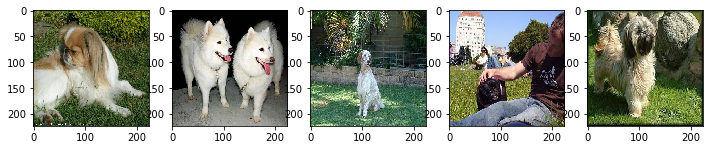

In [229]:
f = plt.figure(figsize=(12,6))
for i, x in enumerate(images[:5]):
    f.add_subplot(1, 5, i + 1)
    plt.imshow(Image.open(x).resize((224,224)))

In [12]:
def run_test(model, loader):
    preds = []
    log_preds = []
    model.eval()
    start_time = time.time()
    print('Running on test set')
    for x, _ in loader:
        with torch.no_grad():
            x_var = x.cuda()

            scores = model(x_var).cpu()
            log_preds += scores.tolist()
            _, _preds = scores.data.max(1)
            preds += _preds.tolist()
    print('Duration = %s' % timedelta(seconds=time.time() - start_time))
    return log_preds, preds

In [14]:
log_preds, preds = run_test(model, test_loader)
results = zip(images, [classes[p] for p in preds])

duration = 0:01:23.834188


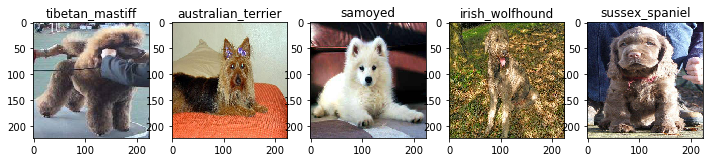

In [237]:
f = plt.figure(figsize=(12,6))
for i, (x, y) in enumerate(itertools.islice(results, 5)):
    f.add_subplot(1, 5, i + 1)
    plt.imshow(Image.open(x).resize((224,224)))
    plt.title(y)

### [Create Submission file for Kaggle](https://youtu.be/9C06ZPF8Uuc?t=32m45s)

In [15]:
probs = np.exp(log_preds)

In [16]:
probs.shape

(10357, 120)

In [17]:
df = pd.DataFrame(probs)

df.columns = classes

df.insert(0, 'id', images_id)

In [18]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,3.095702e-07,2.177687e-07,2.639347e-11,2.726268e-11,2.595513e-09,4.281533e-06,5.086263e-07,6.340644e-09,2.239086e-09,...,1.335511e-06,1.082969e-06,7.037977e-11,5.038979e-10,1.116104e-11,6.009929e-06,8.732311e-08,9.358191e-11,2.058792e-07,2.080477e-06
1,00102ee9d8eb90812350685311fe5890,1.717467e-10,3.032587e-09,8.569065e-12,3.967343e-13,7.689242e-10,9.058440e-08,7.437450e-09,1.474910e-08,8.348655e-12,...,8.005562e-09,4.199153e-08,2.924659e-14,3.790779e-10,2.158684e-11,8.379745e-09,9.687885e-07,1.302712e-11,2.536157e-09,5.174502e-12
2,0012a730dfa437f5f3613fb75efcd4ce,2.285713e-10,6.701441e-08,2.291099e-10,7.825156e-09,2.723834e-08,5.495189e-07,8.961051e-09,9.860700e-11,1.266072e-06,...,3.627774e-09,3.522523e-09,1.167097e-09,4.716986e-08,2.328144e-08,7.485490e-05,3.633529e-09,1.413538e-08,4.343490e-10,7.779113e-09
3,001510bc8570bbeee98c8d80c8a95ec1,6.636556e-08,1.962681e-10,4.600667e-11,2.201022e-10,1.078376e-06,2.624241e-07,9.291499e-10,1.888351e-08,9.255933e-09,...,2.813116e-10,2.333234e-08,2.440305e-10,1.580977e-10,6.369820e-09,1.442333e-09,2.097872e-10,4.543613e-09,1.036802e-11,9.039825e-10
4,001a5f3114548acdefa3d4da05474c2e,5.873383e-07,1.624637e-05,3.286027e-09,3.550612e-08,1.732326e-08,5.766666e-08,4.622724e-07,3.775446e-10,1.303984e-09,...,2.159021e-06,1.570871e-10,1.562530e-11,8.174983e-10,2.175569e-11,4.733850e-08,2.690256e-06,3.344790e-10,1.680869e-07,4.842913e-08


In [19]:
df.to_csv('sub.gz', compression='gzip', index=False)